In [42]:
from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from gurobipy import *

## API Call + Data Preprocessing

In [43]:
# Create a list of symbols
symbols = ["NVDA", "GOOG", "AMZN", "AAPL", "META", "TSLA"]

daily_prices = yf.download(
  tickers = ' '.join(symbols), 
  start = datetime(2023, 12, 29),
  end = datetime(2025, 1, 1)
)['Adj Close']

daily_prices.columns = symbols

# Compute daily simple returns
daily_returns = (
  daily_prices.pct_change()
            .dropna(
              # Drop the first row since we have NaN's
              axis = 0,
              how = 'any',
              inplace = False
              )
)

# daily_returns = daily_returns.reset_index()
daily_returns

[*********************100%%**********************]  6 of 6 completed


,NVDA,GOOG,AMZN,AAPL,META,TSLA
Date,,,,,,
2024-01-02,-0.035787,-0.013229,-0.009721,-0.021669,-0.027341,-0.000241
2024-01-03,-0.007488,-0.009738,0.005732,-0.005256,-0.012436,-0.040134
2024-01-04,-0.012700,-0.026268,-0.016529,0.007693,0.009018,-0.002181
2024-01-05,-0.004013,0.004634,-0.004709,0.013915,0.022897,-0.001849
2024-01-08,0.024175,0.026577,0.022855,0.019065,0.064281,0.012464
...,...,...,...,...,...,...
2024-12-24,0.011478,0.017729,0.008062,0.013170,0.003938,0.073572
2024-12-26,0.003176,-0.008732,-0.002379,-0.007240,-0.002068,-0.017630
2024-12-27,-0.013242,-0.014534,-0.015525,-0.005867,-0.020868,-0.049479


## Optimizing Portfolio
Optimizing the stock portfolio strategy by using the historical volatility and average daily return to minimize risk while ensuring a daily return of at least 0.25%.

In [44]:
# Mean returns and covariance matrix
mean_returns_daily = daily_returns.mean()*100 # returns in %, 
cov_matrix = np.cov(daily_returns.T) # np.cov expects rows to represent variables so .T

# Initialize the model
m = Model("Portfolio")

# Create variables (bounded from 0 to 1 for the proportion each stock represents in portfolio)
weights = m.addVars(len(symbols), lb=0, ub=1, name="weights")

# Set the objective: maximize Sharpe ratio (minimize its negative)
m.setObjective(quicksum(
    weights[i] * cov_matrix[i, j] * weights[j] for i in range(len(symbols)) for j in range(len(symbols))
    ), GRB.MINIMIZE)

# Add constraint: weights must sum to 1
m.addConstr(quicksum(weights[i] for i in range(len(symbols))) == 1, name="weights_sum")

# Add constraint: ensure daily return is at least 0.25%
m.addConstr(quicksum(weights[i] * mean_returns_daily[i] for i in range(len(symbols))) >= 0.25, name='daily_return')

# Optimize the model
m.optimize()

# Print results
if m.status == GRB.OPTIMAL:
    print("Optimal Sharpe Ratio Achieved")
    print("Portfolio Weights:")
    for i, symbol in enumerate(symbols):
        print(f"{symbol}: {weights[i].x}")
else:
    print("No optimal solution found.")

C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_19008\1705935358.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.addConstr(quicksum(weights[i] * mean_returns_daily[i] for i in range(len(symbols))) >= 0.25, name='daily_return')


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x8218c1c2
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+00]
Presolve time: 0.05s
Presolved: 2 rows, 6 columns, 12 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.4912843

## Efficient Frontier

In [45]:
# Initialize an array of target returns
target = np.linspace(
  start = 0.15, 
  stop = 0.35,
  num = 21
)

efficient_frontier  = [] # target return, risk, and list of weights
for target in target:
  # Create a new model for each target
  m = Model("EfficientFrontier")

  # Create variables (bounded from 0 to 1 for the proportion each stock represents in portfolio)
  weights = m.addVars(len(symbols), lb=0, ub=1, name="weights")

  # Set the objective: maximize Sharpe ratio (minimize its negative)
  m.setObjective(quicksum(
      weights[i] * cov_matrix[i, j] * weights[j] for i in range(len(symbols)) for j in range(len(symbols))
      ), GRB.MINIMIZE)

  # Add constraint: weights must sum to 1
  m.addConstr(quicksum(weights[i] for i in range(len(symbols))) == 1, name="weights_sum")

  # Add constraint: ensure daily return is at least target%
  m.addConstr(quicksum(weights[i] * mean_returns_daily[i] for i in range(len(symbols))) >= target, name='daily_return')

  # Optimize the model
  m.optimize()

  # Check if the model has an optimal solution
  if m.status == GRB.OPTIMAL:
      # Portfolio risk (standard deviation is the square root of variance)
      portfolio_variance = m.ObjVal
      portfolio_risk = np.sqrt(portfolio_variance)

      # Extract weights
      portfolio_weights = [weights[i].x for i in range(len(symbols))]

      # Store target return, risk, and weights
      efficient_frontier.append((target, portfolio_risk, portfolio_weights))
  else:
      print(f"No optimal solution found for target return {target}")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))


C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_19008\1216006458.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.addConstr(quicksum(weights[i] * mean_returns_daily[i] for i in range(len(symbols))) >= target, name='daily_return')



CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xc930c380
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
Presolve time: 0.02s
Presolved: 2 rows, 6 columns, 12 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.49128437e+03 -2.49128437e+03  5.00e+03 3.93e-06  2.90e+05     0s
   1   3.52481657e+02 -3

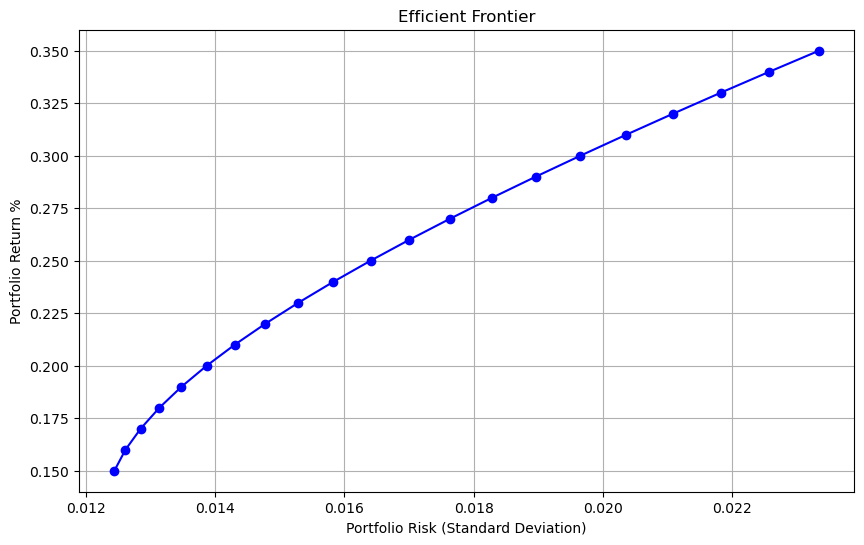

In [46]:
returns, risks, weights = zip(*efficient_frontier) # unpack the vars

plt.figure(figsize=(10, 6))
plt.plot(risks, returns, marker='o', linestyle='-', color='b')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return %')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()